# Room Occupancy with Random Forest Classifier

Create a pipeline for the Random Forest classifier and export for deployment. Evaluate on actual labeled sensor data

Here we:

- set sensor up in a cubby and collected readings
- One or two people enter and leave the cubby recording times of occupancy
- We wrote a script to parse and format data into a csv for evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Read the kaggle csv file and drop unnecessary features for training

Humidity Ratio is a calculated parameter that didn't have much effect on accuracy so it is dropped.

In [2]:
df = pd.read_csv('../../../data/room-occupancy/room-occupancy-2.csv')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [3]:
df.drop(['Light'], axis=1, inplace=True)
df.drop(['date'], axis=1, inplace=True)
df.drop(['HumidityRatio'], axis=1, inplace=True)
df.head()

,Temperature,Humidity,CO2,Occupancy
0,23.7000,26.272,749.200000,1
1,23.7180,26.290,760.400000,1
2,23.7300,26.230,769.666667,1
3,23.7225,26.125,774.750000,1
4,23.7540,26.200,779.000000,1


# Build the Pipeline and Train the Model

Split the data into features (X) and labels (Y).

In [4]:
X = df[['Temperature', 'Humidity', 'CO2']]
Y = df['Occupancy']

Import the necessities

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

Create the train/test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=67, stratify=Y)

Create the pipeline

In [7]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    min_samples_leaf=1
)
pipe = Pipeline([('scaler', MinMaxScaler()), ('rf', rf)])

Fit and test the predictor

In [8]:
pipe.fit(X_train, y_train)

pred, score = pipe.predict(X_test), pipe.score(X_test, y_test)

print('Accuracy:', score*100, '%')

Accuracy: 98.28793774319065 %


# Evaluate the Model

In [9]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3952
           1       0.97      0.96      0.96      1188

    accuracy                           0.98      5140
   macro avg       0.98      0.97      0.98      5140
weighted avg       0.98      0.98      0.98      5140



Let's see the confusion matrix

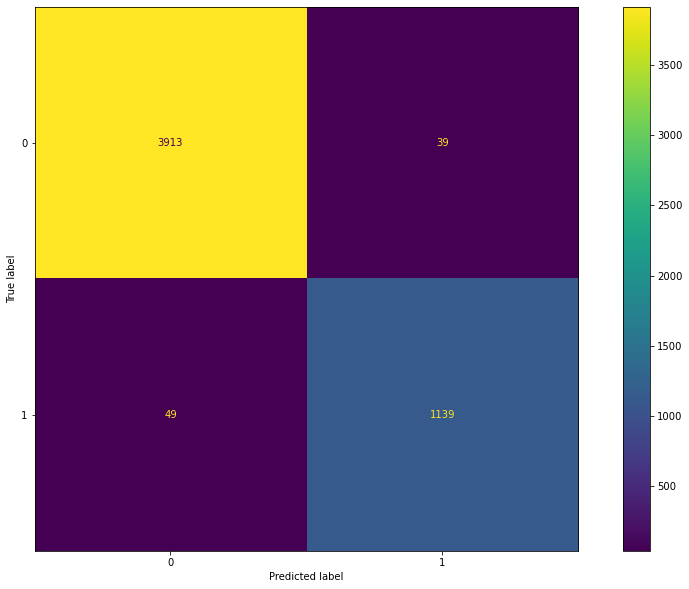

In [11]:
# plot a confusion matrix
#  TN   FP    Off-Vacant        On-vacant
#  FN   TP    Off-occupied      On-Occupied
cm = confusion_matrix(y_test, pred)
cm_display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(16,10))
cm_display.plot(ax=ax)

# Save the model

In [12]:
import pickle

with open('rf-trained-pipeline.pkl','wb') as f:
    pickle.dump(pipe, f)

# Try it out on actual sensor data

In [13]:
snsr = pd.read_csv('../../../data/room-occupancy/results_1666886684.csv')
snsr.head()

,Date,Temperature,Humidity,CO2,Occupancy
0,1666886685,21.4,31.5,674.0,0
1,1666886690,21.4,31.5,671.0,0
2,1666886695,21.4,31.5,673.0,0
3,1666886700,21.4,31.5,676.0,0
4,1666886705,21.4,31.5,676.0,0


In [14]:
snsr.drop(['Date'], axis=1, inplace=True)
snsr.head()

,Temperature,Humidity,CO2,Occupancy
0,21.4,31.5,674.0,0
1,21.4,31.5,671.0,0
2,21.4,31.5,673.0,0
3,21.4,31.5,676.0,0
4,21.4,31.5,676.0,0


In [15]:
snsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  1068 non-null   float64
 1   Humidity     1068 non-null   float64
 2   CO2          1068 non-null   float64
 3   Occupancy    1068 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 33.5 KB


In [16]:
X_snsr = snsr[['Temperature', 'Humidity', 'CO2']]
Y_snsr = snsr['Occupancy']

In [17]:
snsr_pred, snsr_score = pipe.predict(X_snsr), pipe.score(X_snsr, Y_snsr)

print('Accuracy:', snsr_score*100, '%')

Accuracy: 77.52808988764045 %


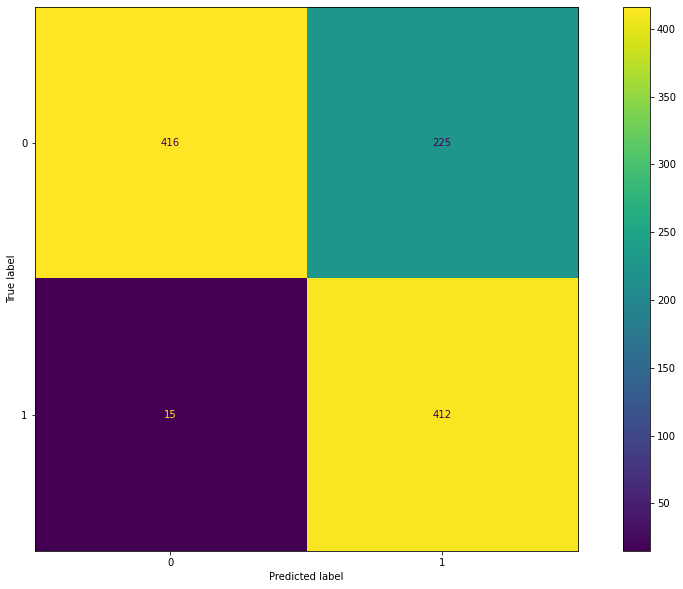

In [19]:
# plot a confusion matrix
#  TN   FP    Off-Vacant        On-vacant
#  FN   TP    Off-occupied      On-Occupied
cm = confusion_matrix(Y_snsr, snsr_pred)
cm_display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(16,10))
cm_display.plot(ax=ax)